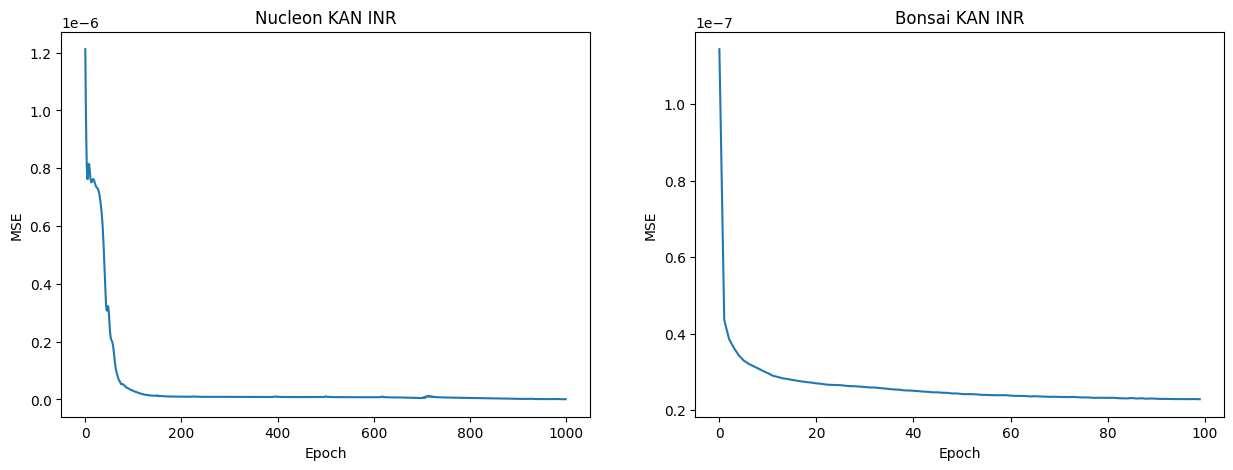

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

nucleon_data = pd.read_csv("nucleon_output.csv")
bonsai_data = pd.read_csv("bonsai_output.csv")

figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(nucleon_data["epoch"], nucleon_data["avg_loss"])
ax1.set_title("Nucleon KAN INR")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("MSE")

ax2.set_title("Bonsai KAN INR")
ax2.plot(bonsai_data["epoch"], bonsai_data["avg_loss"])
ax2.set_xlabel("Epoch")
ax2.set_ylabel("MSE")
figure.show()

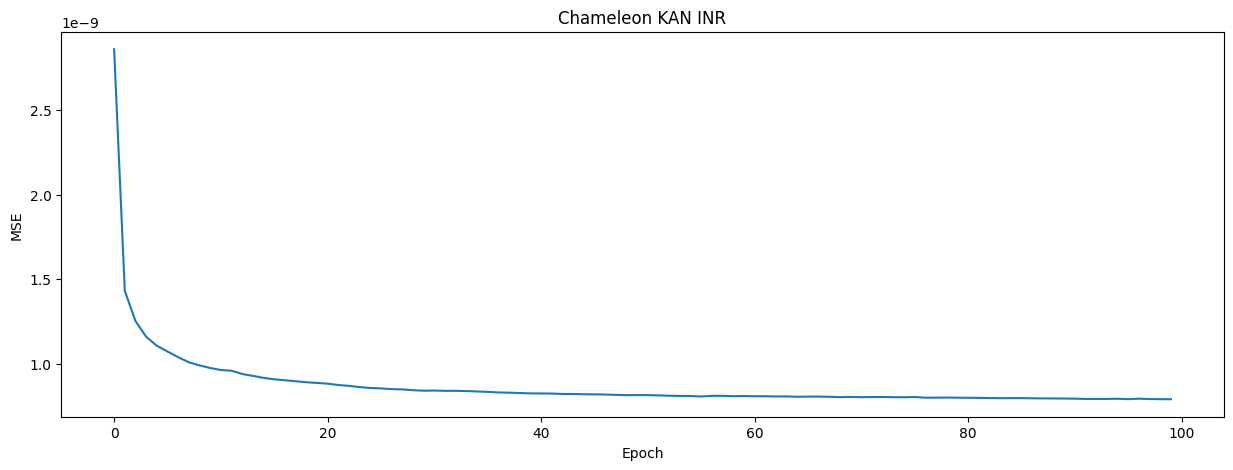

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

chameleon_data = pd.read_csv("chameleon_output.csv")
figure, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(chameleon_data["epoch"], chameleon_data["avg_loss"])
ax.set_title("Chameleon KAN INR")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE")
figure.show()

In [10]:
# Concatenate all .csv result files into one dataframe
from pathlib import Path
import pandas as pd

result_dir = Path("/grand/insitu/cohanlon/results")
agg_file = result_dir / "aggregated_results.csv"

csv_files = list(result_dir.glob("*.csv"))
# Aggregate all csv files into one dataframe and remove each of the original files, then save the new dataframe to a new csv file
dataframes = []
for csv_file in csv_files:
    if csv_file == agg_file:
        continue
    df = pd.read_csv(csv_file)
    dataframes.append(df)
    csv_file.unlink()  # Remove the original file

if dataframes:
    results = pd.concat(dataframes, ignore_index=True)
    results.to_csv(agg_file, index=False)
else:
    results = pd.read_csv(agg_file)

results = results[results["dataset_name"] == "beechnut"]
results.sort_values(by=["compression_ratio"], inplace=True)
results[["compression_ratio", "avg_psnr", "avg_ssim", "avg_mse"]]

,compression_ratio,avg_psnr,avg_ssim,avg_mse
3,122.970736,45.525478,0.979980,0.000028
2,180.352606,45.429329,0.979004,0.000029
7,781.460551,42.954124,0.962891,0.000051
12,3153.109049,41.404633,0.947266,0.000072
14,13350.835476,41.100800,0.942871,0.000078
9,26026.273476,40.809135,0.938477,0.000083
5,47324.434272,40.639114,0.934082,0.000086
1,90711.123944,38.426598,0.899902,0.000144
13,219809.965559,38.406498,0.899902,0.000144


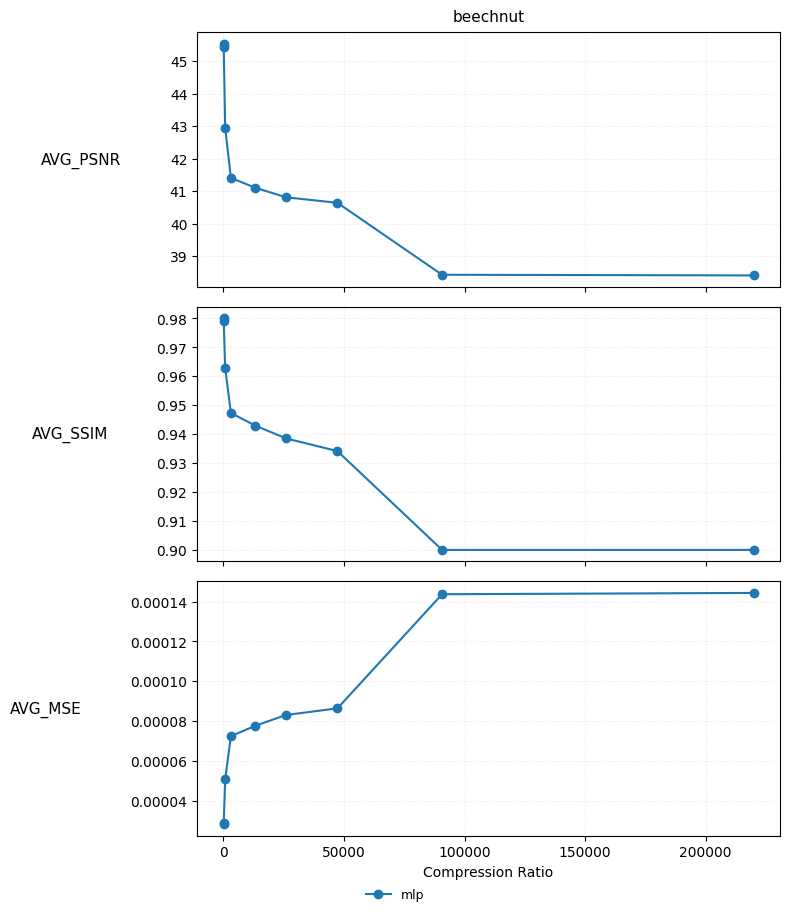

In [ ]:
# %% [markdown]
# Grid layout → **rows = metrics (PSNR, SSIM, MSE)**, **columns = datasets**.
# Every subplot shows *all* models for that dataset in different colors.
# Dataset names sit above columns, metric names on the left.
# A single legend (model ↔ color) appears beneath the entire grid.

# %%
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ----------------- CONFIG -----------------
CSV_PATH = "result.csv"  # ← Update path if needed
METRICS = ["avg_psnr", "avg_ssim", "avg_mse"]  # Row order
INDEPENDENT_VAR = "compression_ratio"
XAXIS_LOG = True  # Log scale for x-axis?
COLOR_CYCLE = plt.rcParams["axes.prop_cycle"].by_key()["color"]
LINE_KW = dict(marker="o", linewidth=1.5)
LEGEND_FONTSIZE = 9

# --------------- LOAD DATA ---------------
df = results
df = df.sort_values(INDEPENDENT_VAR, ascending=True)

datasets = df["dataset_name"].unique()
models = df["network_type"].unique()

n_rows, n_cols = len(METRICS), len(datasets)
# fig_width = 4 * max(1, n_cols)  # width in inches
fig_width = 8
fig_height = 3 * max(1, n_rows)
    

fig, axes = plt.subplots(n_rows, n_cols, sharex="col", figsize=(fig_width, fig_height))

# ---- ensure axes is a true 2‑D array matching (rows, cols) ----
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:  # one metric, many datasets => shape (1, n_cols)
    axes = axes[np.newaxis, :]
elif n_cols == 1:  # many metrics, one dataset => shape (n_rows, 1)
    axes = axes[:, np.newaxis]

# ---------------- PLOT GRID ----------------
for c, ds in enumerate(datasets):
    dset_df = df[df["dataset_name"] == ds]
    for r, metric in enumerate(METRICS):
        ax = axes[r, c]
        for m_ix, model in enumerate(models):
            mdf = dset_df[dset_df["network_type"] == model]
            if mdf.empty:
                continue  # model not present in this dataset
            color = COLOR_CYCLE[m_ix % len(COLOR_CYCLE)]
            ax.plot(
                mdf[INDEPENDENT_VAR], mdf[metric], label=model, color=color, **LINE_KW
            )
        if XAXIS_LOG:
            ax.set_xscale("log")

        # Column & row titles / labels
        if r == 0:
            ax.set_title(ds, fontsize=11, pad=8)
        if c == 0:
            ax.set_ylabel(
                metric.upper(),
                rotation=0,
                ha="right",
                va="center",
                labelpad=35,
                fontsize=11,
            )
        if r == n_rows - 1:
            ax.set_xlabel(INDEPENDENT_VAR.replace("_", " ").title(), fontsize=10)

        ax.grid(True, linestyle=":", linewidth=0.4, alpha=0.5)

# ---------------- GLOBAL LEGEND ----------------
# Collect unique handles/labels (models) from all axes
handles, labels = [], []
seen = set()
for ax in fig.axes:
    for line in ax.get_lines():
        lbl = line.get_label()
        if lbl not in seen and not lbl.startswith("_line"):
            handles.append(line)
            labels.append(lbl)
            seen.add(lbl)
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=len(labels),
    fontsize=LEGEND_FONTSIZE,
    frameon=False,
    bbox_to_anchor=(0.5, -0.02),
)

fig.tight_layout()
plt.show()